_Lambda School Data Science, Unit 2_
 
# Applied Modeling Sprint Challenge

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

### Part 1, Confusion Matrix
- 1.1. Calculate accuracy
- 1.2. Calculate precision
- 1.3. Calculate recall

### Part 2, Log Transformation
- 2.1. Log-transform the target
- 2.2. Plot the target's distribution, before and after the transformation

### Part 3, ROC AUC
- 3.1. Fit classification model
- 3.2. Get ROC AUC score

### Part 4, Model interpretation visualizations
- 4.1. Make _either_ a Partial Dependence Plot _or_ a Shapley Values Force Plot, for either model.

### Stretch Goals
- Get a lower validation error than the example regression model provided in Part 2.
- Find and explain leakage in the classification problem.
- Make _both_ a Partial Dependence Plot _and_ a Shapley Values Force Plot. 


In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install --upgrade category_encoders eli5 pandas-profiling pdpbox plotly shap

In [9]:
# Check category_encoders version
import category_encoders as ce
from distutils.version import StrictVersion
assert StrictVersion(ce.__version__) >= StrictVersion('2.0.0')

# Other libraries
from IPython.display import display
import numpy as np
import pandas as pd

# Part 1, Confusion Matrix

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

## 1.1. Calculate accuracy 

In [4]:
# Accuracy: (TP+TN)/total
total = 85 + 58 + 8 + 36
TN = 85
TP = 36

accuracy = (TP + TN) / total
print('Accuracy: ', accuracy)

Accuracy:  0.6470588235294118


## 1.2. Calculate precision

In [5]:
# Precision: TP/predicted pos
pred_pos = 58 + 36

precision = TP/pred_pos
print('Precision: ', precision)

Precision:  0.3829787234042553


## 1.3. Calculate recall

In [6]:
# Recall: TP/acutal pos
actual_pos = 8 + 36

recall = TP/actual_pos

print('Recall: ', recall)

Recall:  0.8181818181818182


# Part 2, Log Transformation

This part uses real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

There are three dataframes:

- **train**: historical sales data for 120 stores
- **val**: historical sales data for 40 different stores
- **test**: historical sales data for 40 different stores

#### Run this cell to load the data

In [163]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1YWiyOhY_BiECf-vO8_KrknsHd75HqTfs')
val = pd.read_csv('https://drive.google.com/uc?export=download&id=1Azi1KBv63GdzEn2M0x3eYRvekSaLFnPt')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1Ab7mg_Vt_bRL7ObiTLPLHbU3sTiVPzc3')
assert train.shape == (94080, 18)
assert val.shape == (31360, 18)
assert test.shape == (31360, 18)

## 2.1. Log-transform the target, for the train, validation, and test sets.

In [164]:
target = 'Sales'
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [165]:
# Complete this code cell
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)

## 2.2. Plot the distribution of the train set target, before and after the transformation.

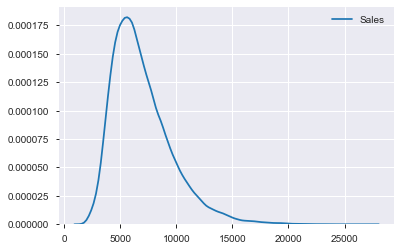

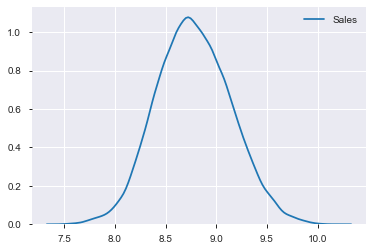

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
ax1 = sns.kdeplot(y_train)
plt.show()
ax2 = sns.kdeplot(y_train_log)
plt.show()

## STRETCH GOAL: Get a lower validation error than this example regression model 

Can you improve on this validation error? Make any changes and use any tools or techniques you want.

Data Dictionary:

- **Store** - a unique Id for each store
- **Year**, **Month**, **Day**, **DayOfWeek** - The date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

(The train, validation, and test sets do _not_ have different date ranges. But they _do_ have different store ids. This problem is _not_ about forecasting future sales from past sales. This problem is about predicting sales at unknown stores, from sales at known stores.)

In [167]:
import category_encoders as ce
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

# Assign to X matrix
features = train.columns.drop([target, 'Store'])
X_train = train[features]
X_val = val[features]
X_test = test[features]

# Define a pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=10, random_state=42)
)

# Fit on train set, with log-transformed target
pipeline.fit(X_train, y_train_log)

# Predict for validation set
y_pred_log = pipeline.predict(X_val)

# Convert prediction's units, from log-sales to sales
y_pred = np.expm1(y_pred_log)

# Get validation mean absolute error
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation Mean Absolute Error: +/− {mae:.0f} sales, on average')

Validation Mean Absolute Error: +/− 859 sales, on average


In [168]:
# Get step names
#pipeline.steps

In [ ]:
# Can try tuning the fandom forest regressor

# Implementation of randomsearchcv
from sklearn.model_selection import RandomizedSearchCV
from time import time

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"randomforestregressor__max_depth": [3, None],
              "randomforestregressor__max_features": [9,10,11,12,13],
              "randomforestregressor__min_samples_split": [2,3,4,5,6,7],
              "randomforestregressor__criterion": ["mse", "mae"]}

# run randomized search
n_iter_search = 1
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_jobs=3,
                                   n_iter=n_iter_search, cv=2, verbose=10, iid=False)

start = time()
random_search.fit(X_train, y_train_log)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [ ]:
# Can't get to complete for some reason.
# Get best and refit/predict


# Part 3, ROC AUC

For this part, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 


#### Your challenge: Predict whether inspections failed.

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data

In [2]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5')
test  = pd.read_csv('https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a')
assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

## 3.1. Fit classification model.

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

Fit a model with the train set. Use cross-validation, or use a three-way split (by randomly splitting the train set into train and validation sets).

In [5]:
# Quick look at data
import pandas_profiling

train.profile_report(style={'full_width':True})

In [44]:
# Copy the dataset and match the column names
train_clean = train.copy()
train_clean.columns = test.columns

test_clean = test.copy()

In [45]:
display(train_clean.columns, test_clean.columns)

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [46]:
# Drop implicit variables that shouldn't vary and indexing variables. Location/longitude seem to be copies
# Also drop variables for time sake: address, city, state
drop_list = ['Address', 'City', 'State', 'Inspection ID', 'Inspection Date', 'License #', 'Location',]

train_clean = train_clean.drop(columns=drop_list)
test_clean = test_clean.drop(columns=drop_list)

In [58]:
categorical_features = train_clean.dtypes[train_clean.dtypes==object].index.tolist()
categorical_features

['DBA Name',
 'AKA Name',
 'Facility Type',
 'Risk',
 'Inspection Type',
 'Violations']

In [59]:
train_clean.dtypes[train_clean.dtypes!=object]

Zip          float64
Latitude     float64
Longitude    float64
Fail           int64
dtype: object

In [63]:
from sklearn.model_selection import train_test_split



In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder()),
     ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

In [79]:
# fit model and calculate predictions
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
# get scores
clf.score(X_val, y_val)

0.7375770416024653

## 3.2. Get ROC AUC score. 

Use your model to predict probabilities that food establishments failed inspections.

Get your Validation ROC AUC score. (Multiple times, if you try multiple iterations.)

Get your Test ROC AUC score. (One time, at the end.)

In [80]:
# get probabalistic predictions
y_pred_val_prob = clf.predict_proba(X_val)[:,0]
y_pred_test_prob = clf.predict_proba(X_test)[:,0]

display(y_pred_test_prob, y_pred_val_prob)

array([0.81524602, 0.69892319, 0.67684588, ..., 0.74152783, 0.75705686,
       0.8112046 ])

array([0.81516371, 0.77150988, 0.8572073 , ..., 0.71852188, 0.67778864,
       0.81388272])

In [81]:
from sklearn.metrics import roc_auc_score

# Compute ROC AUC validation score with probabilities (not sure how this will work)
roc_auc_score(y_val, y_pred_val_prob)

0.5178099279974031

In [84]:
# Compoute ROC AUC val with binary classifications
display(roc_auc_score(y_val, y_pred_val), roc_auc_score(y_test, y_pred_test))


0.5

0.5

In [85]:
# This is a pretty useless model...investigation into ROC/AUC inputs is needed

## STRETCH GOAL: Find and explain leakage

The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

You should be able to get an ROC AUC test score > 0.65 without using the feature with leakage.

# Part 4

## 4.1. Make _either_ a Partial Dependence Plot _or_ a Shapley Values Force Plot, for either model.

Partial Dependence Plot: 1 feature in isolation or 2 features in interaction.

Shapley Values Force Plot: explain an individual prediction.

In [135]:
# Fitting ANOTHER model becaues these can't handle pipelines

from sklearn.ensemble import RandomForestRegressor

train_clean_nona = train_clean.dropna(how='any')

#Split into train/val
X = train_clean_nona.drop(columns='Fail')
y = train_clean_nona.Fail

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Separate test features and target
X_test = test_clean.drop(columns='Fail')
y_test = test_clean.Fail


encoder = ce.OrdinalEncoder()
X_train_trans = encoder.fit_transform(X_train)
#mputer.fit_transform(X_train)


In [136]:
display(X_train_trans.isna().sum(), X_train_trans.dtypes)

DBA Name           0
AKA Name           0
Facility Type      0
Risk               0
Zip                0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
dtype: int64

DBA Name             int32
AKA Name             int32
Facility Type        int32
Risk                 int32
Zip                float64
Inspection Type      int32
Violations           int32
Latitude           float64
Longitude          float64
dtype: object

In [137]:
X_train_trans.head()

,DBA Name,AKA Name,Facility Type,Risk,Zip,Inspection Type,Violations,Latitude,Longitude
12516,1,1,1,1,60631.0,1,1,42.002581,-87.816070
38861,2,2,1,1,60641.0,1,2,41.938522,-87.762128
33754,3,3,1,1,60604.0,1,3,41.878014,-87.633189
51451,4,4,1,1,60606.0,1,4,41.883320,-87.634380
25104,5,5,1,1,60647.0,2,5,41.929763,-87.707223


In [138]:
regr = RandomForestRegressor().fit(X=X_train_trans, y=y_train)

In [157]:
single_row = X_train_trans.iloc[2].to_numpy()
single_row

array([ 3.00000000e+00,  3.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        6.06040000e+04,  1.00000000e+00,  3.00000000e+00,  4.18780145e+01,
       -8.76331890e+01])

In [158]:
import shap


explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(single_row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=single_row
)

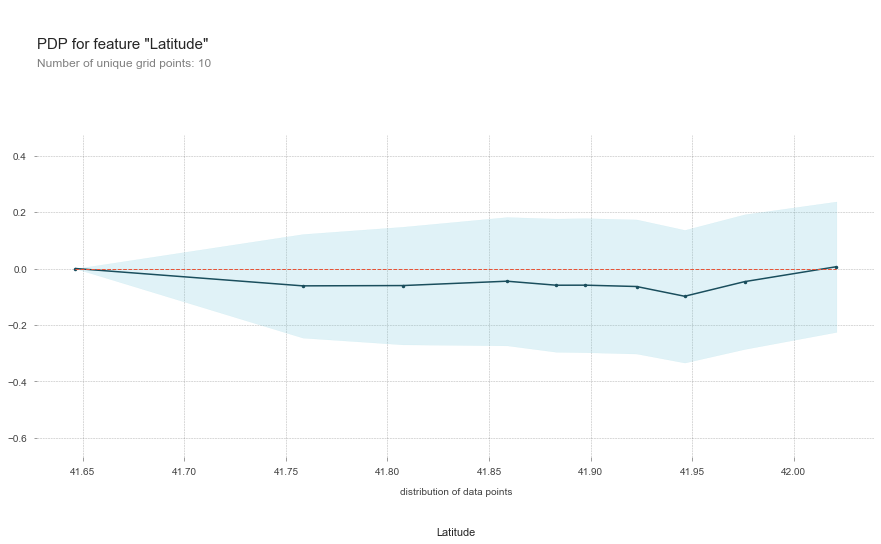

In [160]:
# Error in pdpbox, unsure why.  May be spaces in variable names or missing values.  the library is a bit fragile.
# May also be that pbpbox cannot handle pipelines and the model needs to be sent in directly.  
from pdpbox import pdp

features = X_train.columns.tolist()
feature = 'Latitude'

pdp_latitude = pdp.pdp_isolate(model=regr,
                           dataset=X_train_trans,
                           model_features=features,
                           feature=feature)

fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_latitude, feature_name='Latitude', plot_pts_dist=True)


## STRETCH GOAL: Make _both_ a Partial Dependence Plot _and_ a Shapley Values Force Plot.